# Diabetes Prediction Dataset - Decision Tree Classification model

In [28]:
#Import Necessary Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set visualizations
sns.set(style="whitegrid")

Load the Dataset

In [34]:
# Load the diabetes prediction dataset

df = pd.read_csv(r'C:\Users\Vishnu\Downloads\diabetes_prediction_dataset.csv')

In [36]:
# Preview the dataset
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


Data Preprocessing

In [41]:
# Get information about the dataset
df.info()

# Check for missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [ ]:
# to fill missing values with the median of each column
#df.fillna(df.median(), inplace=True)

In [45]:
# Count duplicate rows
df.duplicated().sum()
# Drop duplicate rows if they exist
df = df.drop_duplicates()


Outlier Handling and Transformations

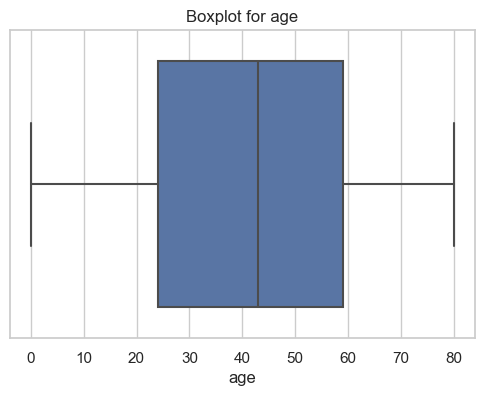

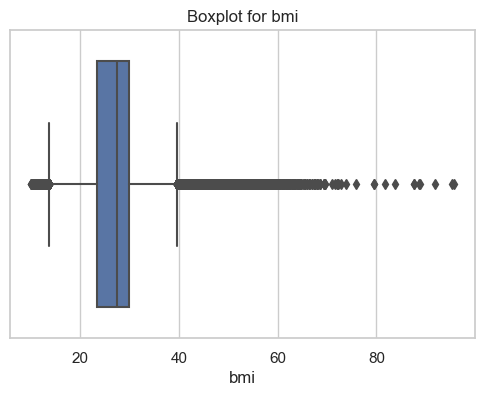

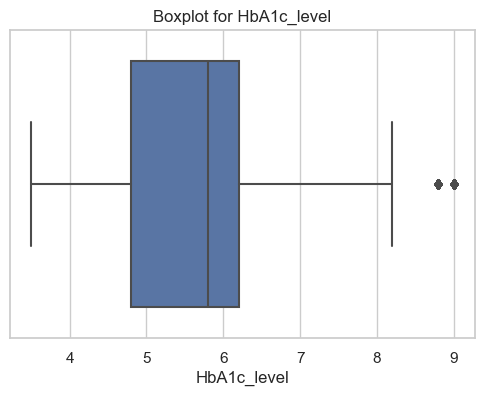

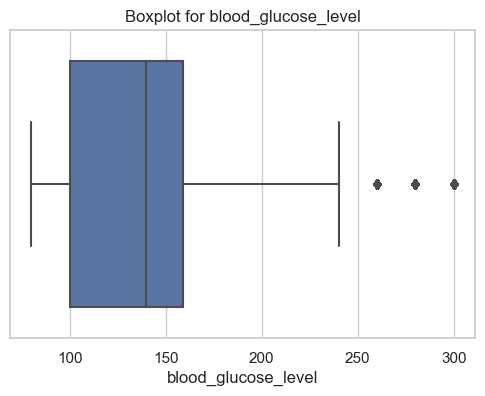

In [48]:
#Visualize Outliers Using Boxplots (Visualize continuous variables using boxplots)
for col in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

In [50]:
#Handling Outliers with IQR Method

def outlier_treatment_IQR(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Capping the outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

# Apply this to continuous columns
for col in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    outlier_treatment_IQR(col)

In [52]:
# Apply logarithmic transformation to skewed features if necessary
df['log_bmi'] = np.log(df['bmi'] + 1)  # Adding 1 to avoid log(0)
df['log_HbA1c_level'] = np.log(df['HbA1c_level'] + 1)

# Drop original columns if log-transformed versions are used
df = df.drop(columns=['bmi', 'HbA1c_level'])


Model Training and Hyperparameter Optimization

In [55]:
#Convert Categorical Variables into Numeric Values
#convert gender and smoking_history using one-hot encoding:


df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

In [57]:

#Separate the features (X) and the target variable (y)

X = df.drop(columns=['diabetes'])
y = df['diabetes']


In [59]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=123)


In [61]:
#initial Model Training
#Train a basic Decision Tree model:


from sklearn.tree import DecisionTreeClassifier

dct = DecisionTreeClassifier(random_state=123)
dct.fit(train_X, train_y)

DecisionTreeClassifier(random_state=123)

In [63]:
#Hyperparameter Optimization Using GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'max_features': [3, 4, 5, 6, 7],
    'max_leaf_nodes': [10, 15, 20, 25, 30]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=123),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1)
grid_search.fit(train_X, train_y)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'max_depth': 8, 'max_features': 7, 'max_leaf_nodes': 30}


In [65]:
#Train the Final Model with Optimal Parameters

final_dct = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    max_leaf_nodes=best_params['max_leaf_nodes'],
    random_state=123
)
final_dct.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=8, max_features=7, max_leaf_nodes=30,
                       random_state=123)

Model Evaluation

In [68]:
#Predict and Evaluate Using ROC-AUC Score

from sklearn import metrics

# Predictions on training and testing data
train_pred = final_dct.predict(train_X)
test_pred = final_dct.predict(test_X)

# Calculate AUC
train_auc = metrics.roc_auc_score(train_y, train_pred)
test_auc = metrics.roc_auc_score(test_y, test_pred)

print('Training AUC:', train_auc)
print('Testing AUC:', test_auc)

Training AUC: 0.8335824700834248
Testing AUC: 0.8396710229445951


In [70]:
#Confusion Matrix and Classification Report


from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:\n", confusion_matrix(test_y, test_pred))
print("\nClassification Report:\n", classification_report(test_y, test_pred))

Confusion Matrix:
 [[26338    11]
 [  799  1696]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     26349
           1       0.99      0.68      0.81      2495

    accuracy                           0.97     28844
   macro avg       0.98      0.84      0.90     28844
weighted avg       0.97      0.97      0.97     28844



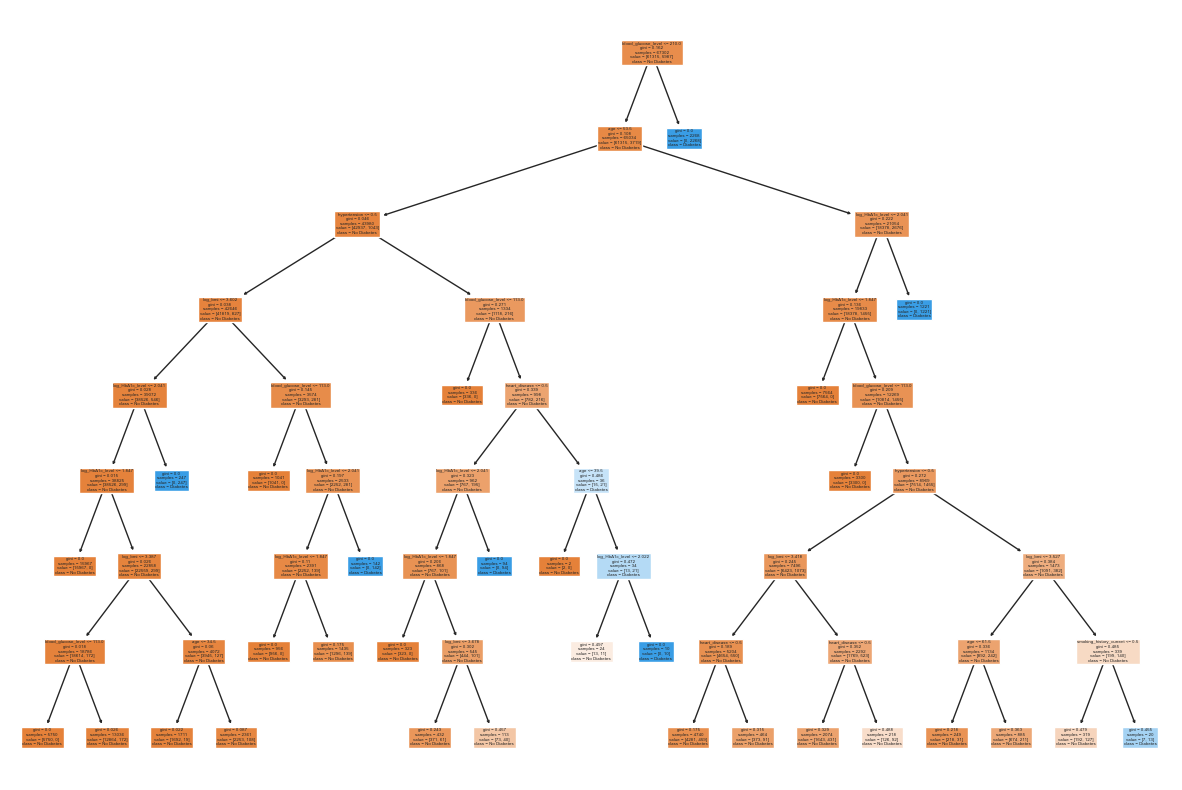

In [72]:
#Visualizing the Decision Tree 

from sklearn.tree import plot_tree

plt.figure(figsize=(15, 10))
plot_tree(final_dct, feature_names=train_X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True)
plt.show()